# Chapter 6.4

In this notebook, we represent two classical portfolio optimization methods: mean-variance optimization and maximum diversification. For mean-variance optimization problem, we seek to minimize variance.

In [1]:
import os 
import sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
project_dir = os.path.dirname(current_dir)
sys.path.append(project_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import ShrunkCovariance

from Utilis.metrics import report_metrics

In [11]:
def max_diversification_weights(data):
    cov_matrix = ShrunkCovariance().fit(data)
    cov_matrix = cov_matrix.covariance_
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    vol_vector = np.array(data.std())
    vol_vector = vol_vector.reshape(len(vol_vector), 1)

    numerator = np.dot(inv_cov_matrix, vol_vector)
    numerator = numerator.reshape(len(numerator),)
    denominator = np.dot(np.dot(vol_vector.T, inv_cov_matrix), vol_vector)[0]
    weights = numerator / denominator
    weights = weights * vol_vector.reshape(vol_vector.shape[0],)
    return weights

def min_variance_weights(data):
    T, D = data.shape
    cov_matrix = ShrunkCovariance().fit(data)
    cov_matrix = cov_matrix.covariance_
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    vol_vector = np.ones(D)
    vol_vector = vol_vector.reshape(len(vol_vector), 1)

    numerator = np.dot(inv_cov_matrix, vol_vector)
    numerator = numerator.reshape(len(numerator),)
    denominator = np.dot(np.dot(vol_vector.T, inv_cov_matrix), vol_vector)[0]
    weights = numerator / denominator

    return weights

def create_strategy(data, history_t, method):
    all_weights = [] 
    for i in range(history_t, len(data)):
        state = data[i-history_t:i]
        if method == 'maximum_diversification':
            weights = max_diversification_weights(state) # maximum diversification    
        elif method == 'min_variance':
            weights = min_variance_weights(state) # global minimum variance    
        all_weights.append(weights)
    all_weights = np.array(all_weights)    
    all_weights[0] = 0
    all_weights[-1] = 0

    port_ret = np.array(data[history_t:]) * np.array(all_weights)[:]
    port_ret = np.sum(port_ret, axis=1)
    port_cumret = np.cumsum(port_ret)
    return all_weights, port_ret, port_cumret

In [12]:
df = pd.read_csv('../Data/portfolio_data.csv')
ticker_list = ['AXP', 'CI', 'GD', 'HON', 'MMM',
              'MO', 'MRK', 'PFE', 'PG', 'SO',
              'NEM', 'NSC', 'GE', 'AEP', 'AAPL', 
              'ABT', 'SNA', 'PTC', 'BAC', 'NKE'] 

df = df[[tic + '_Return' for tic in ticker_list]]
print(df.head())

   AXP_Return  CI_Return  GD_Return  ...  PTC_Return  BAC_Return  NKE_Return
0    0.027623   0.015626  -0.020305  ...   -0.011792    0.007501   -0.016901
1   -0.005376  -0.002198  -0.014248  ...    0.021480    0.002481    0.004298
2   -0.010811   0.000000   0.019711  ...    0.000000    0.005489   -0.015691
3   -0.016393   0.000000   0.020618  ...   -0.014019    0.004963   -0.015942
4    0.011111  -0.004406  -0.010102  ...   -0.014218   -0.002469   -0.017673

[5 rows x 20 columns]


In [13]:
history_t = 60
df_md_weights, df_md_ret, df_md_cumret = create_strategy(df, history_t, method='maximum_diversification')
df_min_var_weights, df_min_var_ret, df_min_var_cumret = create_strategy(df, history_t, method='min_variance')


In [15]:
print(report_metrics(df_md_ret))
print(report_metrics(df_min_var_ret))

{'annual_ret': np.float64(0.16369834504902592), 'annual_std': np.float64(0.20643218815016515), 'annual_sharpe': np.float64(0.7929884700439579)}
{'annual_ret': np.float64(0.1299740607711181), 'annual_std': np.float64(0.1410464977791178), 'annual_sharpe': np.float64(0.9214979656897302)}


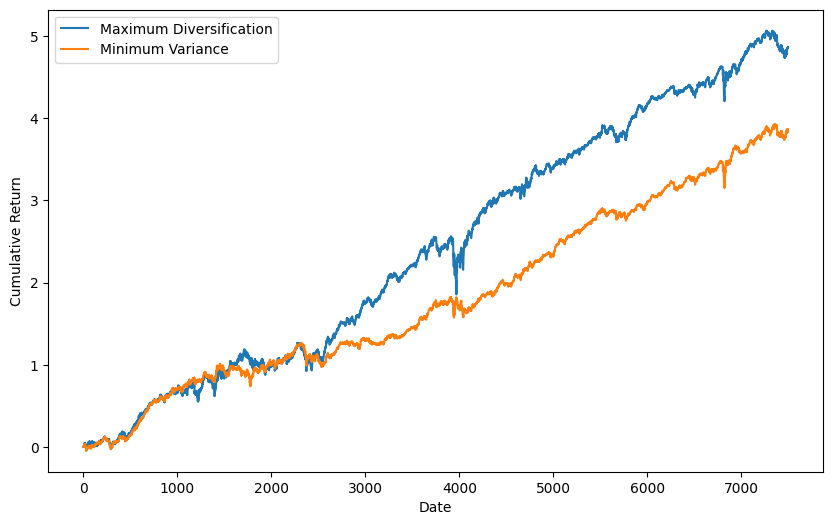

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_md_cumret, label="Maximum Diversification")
plt.plot(df_min_var_cumret, label="Minimum Variance")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()